In [1]:
import pandas as pd
from validation.validate import plot_geoframes, plot_aggregated_kpis, plot_error_distributions, validate_results
import geopandas as gp
from sign_locator.sign_locator import SignLocator
from gps_emitter.gps_trace_emitter import emit_traces

In [2]:
input_df = pd.read_csv("input_data/verkehrszeichen.csv", delimiter=",")

In [3]:
df = emit_traces(input_df)

# and a sample sign
sample_uuid = df["uuid"].iloc[0]
subset = df[df["uuid"] == sample_uuid]

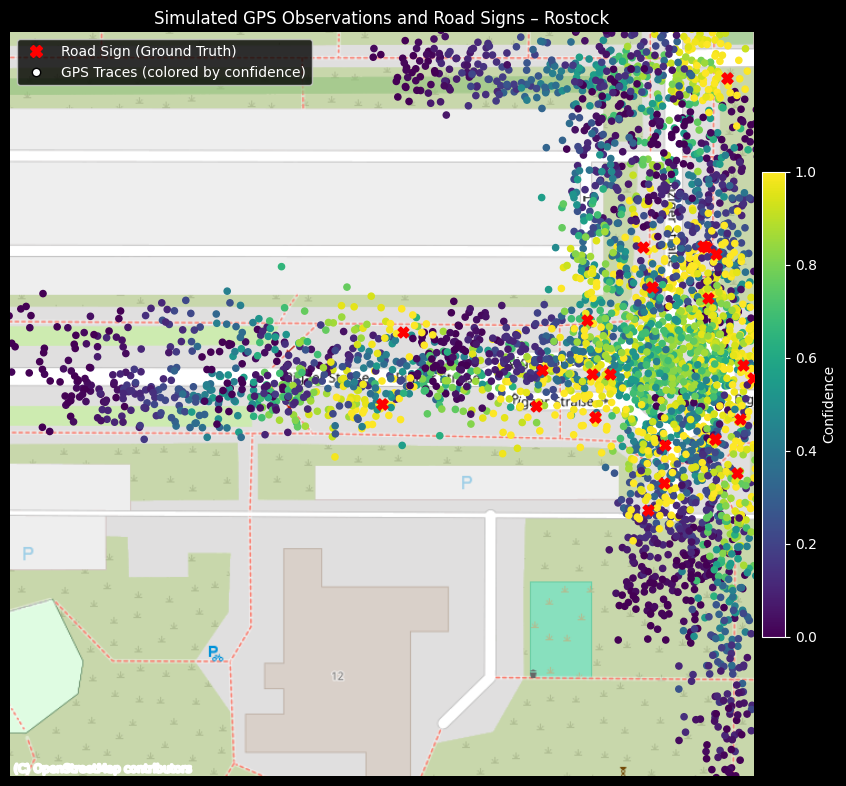

In [4]:
# let's plot the traces now so that we understand our simulated input dataset better
gdf = gp.GeoDataFrame(
    df, geometry=gp.points_from_xy(df["gps_traces_lon"], df["gps_traces_lat"]), crs="EPSG:4326"
)

# we also want the ground truth - the real road sign positions
df_signs = input_df[["uuid", "latitude", "longitude"]].drop_duplicates()

gdf_signs = gp.GeoDataFrame(
    df_signs,
    geometry=gp.points_from_xy(df_signs["longitude"], df_signs["latitude"]),
    crs="EPSG:4326"
)

plot_geoframes("Simulated GPS Observations and Road Signs – Rostock", gdf_signs, {"GPS Traces": (gdf, {"cmap": "viridis"})})

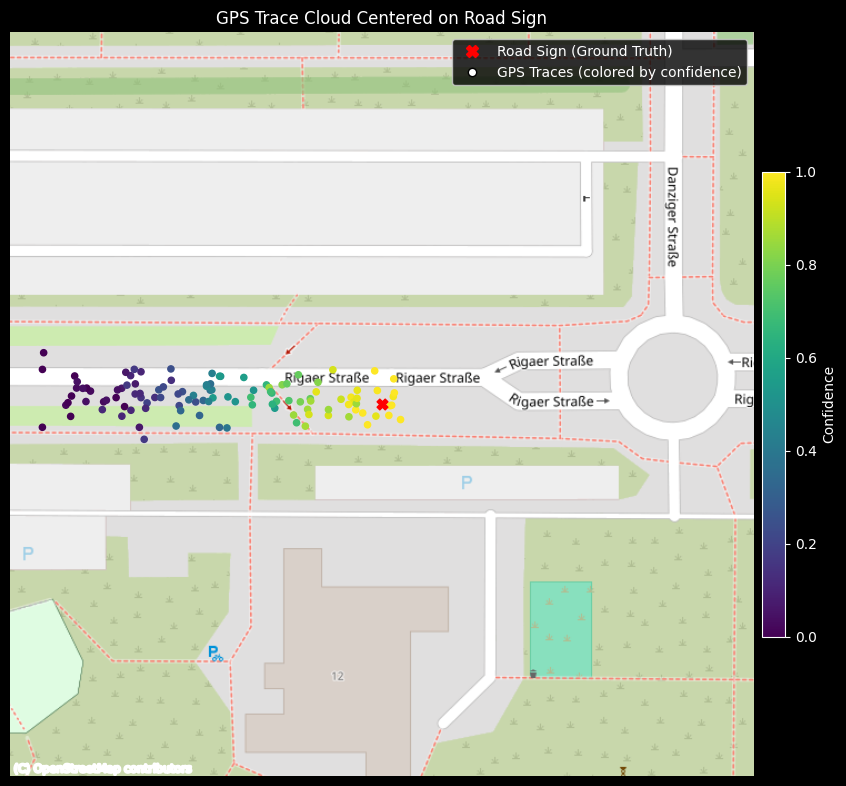

In [5]:
# let's focus on a single road sign now
obs_sub = gdf[gdf["uuid"] == sample_uuid]
sign_sub = gdf_signs[gdf_signs["uuid"] == sample_uuid]

plot_geoframes("GPS Trace Cloud Centered on Road Sign", sign_sub, {"GPS Traces": (obs_sub, {"cmap": "viridis"})})

In [6]:
# lets start our ETL and process the traces to locate the road signs correctly
sign_locator = SignLocator()
signs_df = sign_locator.extract_traces(df)
gdf_points_simple, gdf_tiles = sign_locator.calculate_sign_locations(signs_df, center_calc="simple")

Iteration 0: 1103435 points
Iteration 1: 40398 points
Iteration 2: 17919 points
Iteration 3: 17904 points
Converged after 4 iterations


In [7]:
gdf_points_dbscan, _ = sign_locator.calculate_sign_locations(signs_df, center_calc="DBSCAN", min_samples=9, min_radius=4.5)

In [8]:
# lets start our ETL and process the traces to locate the road signs correctly
gdf_points_kmeans, _ = sign_locator.calculate_sign_locations(signs_df, center_calc="k-means", min_samples=9, min_radius=4.5)

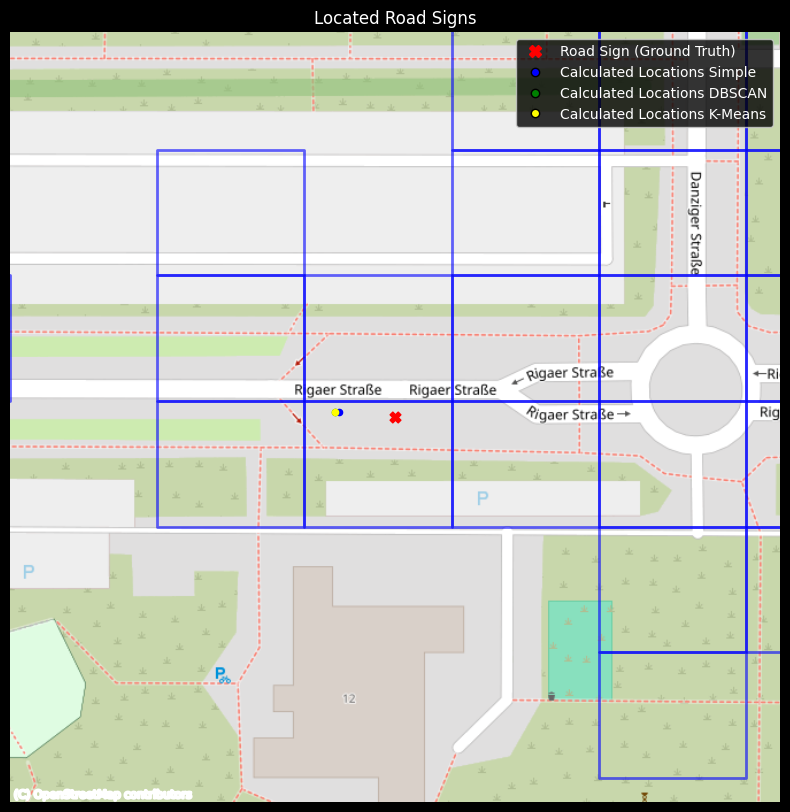

In [9]:
# let's focus on a single road sign now
sign_sub = gdf_signs[gdf_signs["uuid"] == sample_uuid]

traces_dict = {
    "Calculated Locations Simple": (gdf_points_simple[gdf_points_simple["uuid"] == sample_uuid], {"color": "blue"}),
    "Calculated Locations DBSCAN": (gdf_points_dbscan[gdf_points_dbscan["uuid"] == sample_uuid], {"color": "green"}),
    "Calculated Locations K-Means": (gdf_points_kmeans[gdf_points_kmeans["uuid"] == sample_uuid], {"color": "yellow"}),
}

plot_geoframes("Located Road Signs", sign_sub, traces_dict, gdf_tiles)

In [10]:
val_simple = validate_results(gdf_points_simple, gdf_signs, "Simple")
val_dbscan = validate_results(gdf_points_dbscan, gdf_signs, "DBSCAN")
val_kmeans = validate_results(gdf_points_kmeans, gdf_signs, "k-Means")

validation_all = pd.concat([val_simple, val_dbscan, val_kmeans], ignore_index=True)

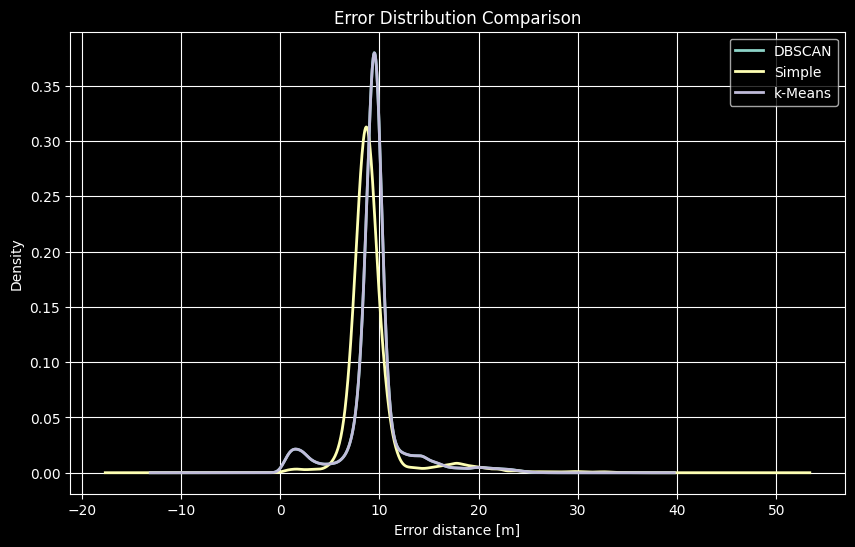

In [11]:
plot_error_distributions(validation_all)

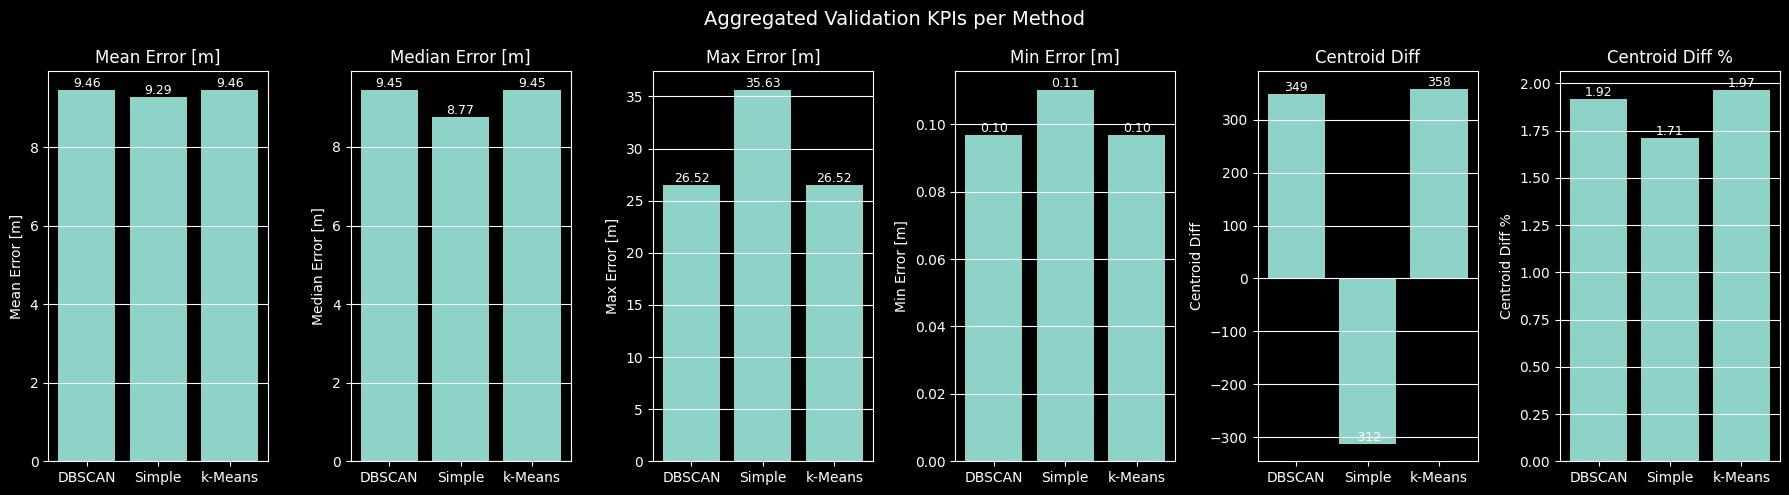

In [12]:
plot_aggregated_kpis(validation_all, gdf_signs)